In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.io import read_image
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm
import warnings

In [2]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [3]:
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Cuda available: ", torch.cuda.is_available())

seed = 1998
torch.manual_seed(seed)

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)

epochs = 30
batch_size = 64
lr = 1e-4
wd = 1e-4

Cuda available:  True


In [4]:
!wget -c https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz

--2022-02-28 20:27:28--  https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.88.42
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.88.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345236087 (329M) [application/x-tar]
Saving to: ‘oxford-102-flowers.tgz’

oxford-102-flowers. 100%[===================>] 329.24M  52.9MB/s    in 6.8s    

2022-02-28 20:27:35 (48.3 MB/s) - ‘oxford-102-flowers.tgz’ saved [345236087/345236087]



In [5]:
!tar -xvzf oxford-102-flowers.tgz

Streaming output truncated to the last 5000 lines.
oxford-102-flowers/jpg/image_07751.jpg
oxford-102-flowers/jpg/image_07634.jpg
oxford-102-flowers/jpg/image_01310.jpg
oxford-102-flowers/jpg/image_03097.jpg
oxford-102-flowers/jpg/image_05968.jpg
oxford-102-flowers/jpg/image_00448.jpg
oxford-102-flowers/jpg/image_07792.jpg
oxford-102-flowers/jpg/image_07265.jpg
oxford-102-flowers/jpg/image_03343.jpg
oxford-102-flowers/jpg/image_00210.jpg
oxford-102-flowers/jpg/image_03833.jpg
oxford-102-flowers/jpg/image_03993.jpg
oxford-102-flowers/jpg/image_02316.jpg
oxford-102-flowers/jpg/image_02991.jpg
oxford-102-flowers/jpg/image_06135.jpg
oxford-102-flowers/jpg/image_05413.jpg
oxford-102-flowers/jpg/image_04386.jpg
oxford-102-flowers/jpg/image_01073.jpg
oxford-102-flowers/jpg/image_06546.jpg
oxford-102-flowers/jpg/image_01521.jpg
oxford-102-flowers/jpg/image_03887.jpg
oxford-102-flowers/jpg/image_00149.jpg
oxford-102-flowers/jpg/image_00921.jpg
oxford-102-flowers/jpg/image_02386.jpg
oxford-102-fl

In [6]:
resnet = models.resnet34(pretrained=True)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, delim_whitespace=True)
        self.img_dir = img_dir
        images = []
        for idx in tqdm(range(self.__len__())):
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))
            image = read_image(img_path)
            images.append(image)
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
trans = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(256,256)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [9]:
train_data = CustomImageDataset("/content/oxford-102-flowers/train.txt", "/content/oxford-102-flowers", transform=trans)
test_data = CustomImageDataset("/content/oxford-102-flowers/test.txt", "/content/oxford-102-flowers", transform=trans)
val_data = CustomImageDataset("/content/oxford-102-flowers/valid.txt", "/content/oxford-102-flowers", transform=trans)

100%|██████████| 1019/1019 [00:04<00:00, 218.26it/s]


In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [11]:
def train(model):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    running_loss = 0
    total_steps = 0
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_steps += 1

    return running_loss / total_steps

In [12]:
def eval(loader, model):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader)):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            test_loss += F.cross_entropy(output, labels, reduction='sum').item()
            prd = output.argmax(1)
            correct += torch.sum(labels == prd)
    test_loss /= len(loader.dataset)
    # test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))

In [13]:
def run(model, eps=epochs):
    losses = []
    for e in range(eps):
        print(f"\nepoch {e + 1}/{eps}")
        loss = train(model)
        print(f" loss = {loss}")
        print("accuracy on validation set")
        eval(val_loader, resnet)
        losses.append(loss)
    plt.plot(range(len(losses)), losses)
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.title("loss change during training")
    plt.show()


epoch 1/30


16it [00:21,  1.37s/it]


 loss = 6.996942311525345
accuracy on validation set


16it [00:09,  1.62it/s]



Test set: Avg. loss: 4.5491, Accuracy: 206/1019 (20%)


epoch 2/30


16it [00:21,  1.32s/it]


 loss = 1.919817954301834
accuracy on validation set


16it [00:09,  1.61it/s]



Test set: Avg. loss: 2.3029, Accuracy: 579/1019 (57%)


epoch 3/30


16it [00:21,  1.33s/it]


 loss = 0.34054448921233416
accuracy on validation set


16it [00:09,  1.60it/s]



Test set: Avg. loss: 1.7350, Accuracy: 701/1019 (69%)


epoch 4/30


16it [00:21,  1.33s/it]


 loss = 0.05525218159891665
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.5371, Accuracy: 696/1019 (68%)


epoch 5/30


16it [00:21,  1.32s/it]


 loss = 0.032118966337293386
accuracy on validation set


16it [00:09,  1.62it/s]



Test set: Avg. loss: 1.4770, Accuracy: 707/1019 (69%)


epoch 6/30


16it [00:21,  1.32s/it]


 loss = 0.021044256194727495
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.2569, Accuracy: 764/1019 (75%)


epoch 7/30


16it [00:21,  1.34s/it]


 loss = 0.006622758461162448
accuracy on validation set


16it [00:09,  1.62it/s]



Test set: Avg. loss: 1.2817, Accuracy: 750/1019 (74%)


epoch 8/30


16it [00:21,  1.33s/it]


 loss = 0.0025541293289279565
accuracy on validation set


16it [00:09,  1.62it/s]



Test set: Avg. loss: 1.1418, Accuracy: 795/1019 (78%)


epoch 9/30


16it [00:21,  1.33s/it]


 loss = 0.01370336606487399
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.4890, Accuracy: 714/1019 (70%)


epoch 10/30


16it [00:21,  1.32s/it]


 loss = 0.010644668240274768
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.3780, Accuracy: 740/1019 (73%)


epoch 11/30


16it [00:21,  1.33s/it]


 loss = 0.013536291764467023
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.6640, Accuracy: 680/1019 (67%)


epoch 12/30


16it [00:21,  1.32s/it]


 loss = 0.020717826948384754
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.2009, Accuracy: 763/1019 (75%)


epoch 13/30


16it [00:21,  1.33s/it]


 loss = 0.002328550697711762
accuracy on validation set


16it [00:10,  1.56it/s]



Test set: Avg. loss: 1.2922, Accuracy: 760/1019 (75%)


epoch 14/30


16it [00:21,  1.33s/it]


 loss = 0.0023088325178832747
accuracy on validation set


16it [00:10,  1.59it/s]



Test set: Avg. loss: 1.2150, Accuracy: 759/1019 (74%)


epoch 15/30


16it [00:21,  1.33s/it]


 loss = 0.005066774490842363
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.6749, Accuracy: 671/1019 (66%)


epoch 16/30


16it [00:21,  1.32s/it]


 loss = 0.0012722867941192817
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.2010, Accuracy: 772/1019 (76%)


epoch 17/30


16it [00:21,  1.32s/it]


 loss = 0.0008008121876628138
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.2181, Accuracy: 764/1019 (75%)


epoch 18/30


16it [00:21,  1.32s/it]


 loss = 0.00058535369225865
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 0.9959, Accuracy: 829/1019 (81%)


epoch 19/30


16it [00:21,  1.32s/it]


 loss = 0.0004812354763998883
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 0.9762, Accuracy: 837/1019 (82%)


epoch 20/30


16it [00:21,  1.32s/it]


 loss = 0.0007898090125308954
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.0412, Accuracy: 818/1019 (80%)


epoch 21/30


16it [00:21,  1.32s/it]


 loss = 0.0011624829021457117
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.1060, Accuracy: 809/1019 (79%)


epoch 22/30


16it [00:21,  1.33s/it]


 loss = 0.0008417173330599326
accuracy on validation set


16it [00:10,  1.59it/s]



Test set: Avg. loss: 1.3361, Accuracy: 762/1019 (75%)


epoch 23/30


16it [00:21,  1.34s/it]


 loss = 0.0007261866103362991
accuracy on validation set


16it [00:10,  1.60it/s]



Test set: Avg. loss: 1.1289, Accuracy: 802/1019 (79%)


epoch 24/30


16it [00:21,  1.32s/it]


 loss = 0.0018892983589466894
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.3863, Accuracy: 759/1019 (74%)


epoch 25/30


16it [00:21,  1.32s/it]


 loss = 0.007436935164150782
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.2103, Accuracy: 800/1019 (79%)


epoch 26/30


16it [00:21,  1.32s/it]


 loss = 0.00790071276242088
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.1387, Accuracy: 788/1019 (77%)


epoch 27/30


16it [00:21,  1.33s/it]


 loss = 0.006223919928743271
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.4582, Accuracy: 737/1019 (72%)


epoch 28/30


16it [00:21,  1.31s/it]


 loss = 0.002811031117744278
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.0295, Accuracy: 807/1019 (79%)


epoch 29/30


16it [00:21,  1.32s/it]


 loss = 0.009160124056506902
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.5642, Accuracy: 748/1019 (73%)


epoch 30/30


16it [00:21,  1.32s/it]


 loss = 0.004256941587300389
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)



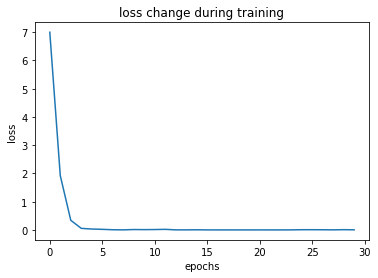

In [14]:
run(resnet, epochs)

In [15]:
eval(test_loader, resnet)

97it [00:59,  1.64it/s]


Test set: Avg. loss: 2.1576, Accuracy: 3675/6148 (60%)




epoch 1/30


16it [00:21,  1.35s/it]


 loss = 6.997447669506073
accuracy on validation set


16it [00:09,  1.65it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 2/30


16it [00:21,  1.34s/it]


 loss = 1.9401727691292763
accuracy on validation set


16it [00:09,  1.65it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 3/30


16it [00:21,  1.35s/it]


 loss = 0.3596546445041895
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 4/30


16it [00:21,  1.35s/it]


 loss = 0.07102591102011502
accuracy on validation set


16it [00:10,  1.59it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 5/30


16it [00:21,  1.37s/it]


 loss = 0.024602901423349977
accuracy on validation set


16it [00:10,  1.59it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 6/30


16it [00:21,  1.37s/it]


 loss = 0.017523362635984086
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 7/30


16it [00:21,  1.35s/it]


 loss = 0.009943911121808924
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 8/30


16it [00:21,  1.35s/it]


 loss = 0.012115639066905715
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 9/30


16it [00:21,  1.35s/it]


 loss = 0.011143226518470328
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 10/30


16it [00:21,  1.36s/it]


 loss = 0.0029904353505116887
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 11/30


16it [00:21,  1.35s/it]


 loss = 0.008951441384851933
accuracy on validation set


16it [00:09,  1.62it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 12/30


16it [00:21,  1.36s/it]


 loss = 0.006811891471443232
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 13/30


16it [00:21,  1.36s/it]


 loss = 0.01058095387998037
accuracy on validation set


16it [00:09,  1.61it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 14/30


16it [00:21,  1.35s/it]


 loss = 0.0018103242182405666
accuracy on validation set


16it [00:09,  1.63it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 15/30


16it [00:21,  1.35s/it]


 loss = 0.0008297976492031012
accuracy on validation set


16it [00:09,  1.64it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 16/30


16it [00:21,  1.37s/it]


 loss = 0.002242207367089577
accuracy on validation set


16it [00:10,  1.57it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 17/30


16it [00:21,  1.37s/it]


 loss = 0.003348312488014926
accuracy on validation set


16it [00:10,  1.57it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 18/30


16it [00:22,  1.38s/it]


 loss = 0.001172320953628514
accuracy on validation set


16it [00:10,  1.58it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 19/30


16it [00:21,  1.37s/it]


 loss = 0.0006513394819194218
accuracy on validation set


16it [00:10,  1.58it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 20/30


16it [00:22,  1.38s/it]


 loss = 0.001531772225007444
accuracy on validation set


16it [00:10,  1.58it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 21/30


16it [00:21,  1.37s/it]


 loss = 0.0022040295334591065
accuracy on validation set


16it [00:10,  1.57it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 22/30


16it [00:21,  1.37s/it]


 loss = 0.0007481825268769171
accuracy on validation set


16it [00:09,  1.60it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 23/30


16it [00:21,  1.37s/it]


 loss = 0.0029587752505904064
accuracy on validation set


16it [00:10,  1.59it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 24/30


16it [00:21,  1.37s/it]


 loss = 0.009561872499034507
accuracy on validation set


16it [00:09,  1.60it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 25/30


16it [00:21,  1.36s/it]


 loss = 0.0020894596509606345
accuracy on validation set


16it [00:09,  1.65it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 26/30


16it [00:21,  1.35s/it]


 loss = 0.01130867078245501
accuracy on validation set


16it [00:09,  1.66it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 27/30


16it [00:21,  1.35s/it]


 loss = 0.005135873114340939
accuracy on validation set


16it [00:09,  1.65it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 28/30


16it [00:21,  1.35s/it]


 loss = 0.007129112742404686
accuracy on validation set


16it [00:09,  1.66it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 29/30


16it [00:21,  1.34s/it]


 loss = 0.016871576228368212
accuracy on validation set


16it [00:09,  1.65it/s]



Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)


epoch 30/30


16it [00:21,  1.34s/it]


 loss = 0.00700946343022224
accuracy on validation set


16it [00:09,  1.67it/s]


Test set: Avg. loss: 1.9133, Accuracy: 654/1019 (64%)



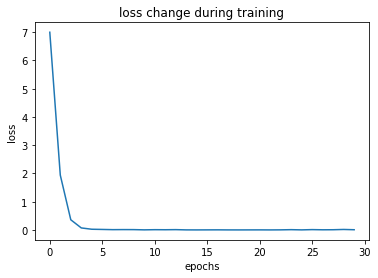

97it [00:58,  1.66it/s]


Test set: Avg. loss: 1.7870, Accuracy: 4263/6148 (69%)



In [16]:
# Use Cutout
cutout_trans = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(256,256)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    Cutout(n_holes=1, length=16),
])
train_data.transform = cutout_trans
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
cutout_resnet = models.resnet34(pretrained=True)
cutout_resnet.to(device)
run(cutout_resnet, epochs)
eval(test_loader, cutout_resnet)

In [17]:
eval(test_loader, cutout_resnet)

97it [01:02,  1.54it/s]


Test set: Avg. loss: 1.7870, Accuracy: 4263/6148 (69%)

